In [1]:
from pennystockpipeline.PennyStockData import PennyStockData
import numpy as np
import pandas as pd
from time import gmtime, strftime
from datetime import datetime, timedelta

## Initializing
DATABASE_NAME_WITH_PATH = "mod_historicaldata.db"
TABLE_NAME = "all_historical_modified"

#psd = PennyStockData(database_name_with_path, table_name, impute=True, verbose=2).get_columns(columns).normalize(['close', 'volume_weighted_average']).create_sequences(sequence_length, prediction_length)
psd = PennyStockData(DATABASE_NAME_WITH_PATH, TABLE_NAME, impute=True, verbose=2)


[DEBUG][PennyStockData]: Imputed len(data): 965607
2024-06-01


In [2]:
import torch
#columns = ['ticker_id', 'p_date', 'close', 'volume_weighted_average']
COLUMNS = ['ticker_id', 'p_date', 'p_time', 'volume_weighted_average']
COLUMNS_TO_NORMALIZE = ['volume_weighted_average']

SEQUENCE_LENGTH = 20
PREDICTION_LENGTH = 20

TRAIN_TEST_SPLIT = 0.8
psd = psd.get_columns(COLUMNS).normalize(COLUMNS_TO_NORMALIZE).create_sequences(SEQUENCE_LENGTH, PREDICTION_LENGTH).split_dataset(split=TRAIN_TEST_SPLIT, to_torch=True)


[INFO][PennyStockData]: Performing ticker-wise normalization on ['volume_weighted_average']
[INFO][PennyStockData]: Performing global normalization on ['volume_weighted_average'] using MixMaxScaler
x_train.shape: (32408, 20, 1), y_train.shape: (32408, 20, 1)
x_test.shape: (8102, 20, 1), y_test.shape: (8102, 20, 1)


In [3]:
# Library for implementing Deep Neural Network 
from pennystockpipeline.PennyStockModel import PennyStockModel

# Prepare model parameters
INPUT_SIZE = len(COLUMNS_TO_NORMALIZE)
NUM_LAYERS = 2
HIDDEN_SIZE = 64
OUTPUT_SIZE = len(COLUMNS_TO_NORMALIZE)

# Define the model, loss function, and optimizer
model = PennyStockModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, device='cuda')
model = model.to(model.device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)



PennyStockModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [4]:
BATCH_SIZE = 16

# Pass the dataset and prepare the dataloaders
model = model.create_dataloaders(psd, BATCH_SIZE)


Epoch [10/50] - Training Loss: 0.0003, Test Loss: 0.0002
Epoch [20/50] - Training Loss: 0.0002, Test Loss: 0.0002
Epoch [30/50] - Training Loss: 0.0002, Test Loss: 0.0003
Epoch [40/50] - Training Loss: 0.0002, Test Loss: 0.0002
Epoch [50/50] - Training Loss: 0.0002, Test Loss: 0.0002


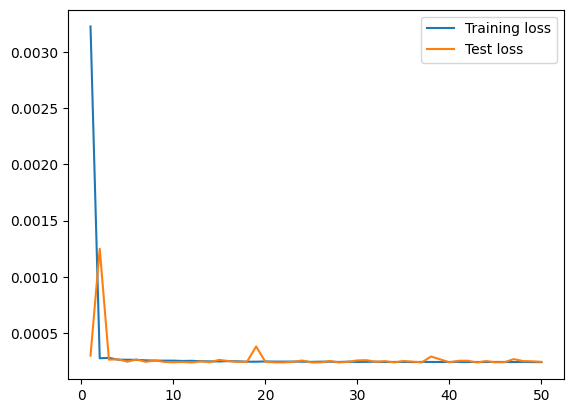

In [5]:
NUM_EPOCHS = 50
# Train the model
model = model.train_model(loss_fn, optimizer, num_epochs = NUM_EPOCHS).plot_training_test_loss()


In [14]:
FORECAST_STEPS = 20
model = model.forecast(num_forecast_steps = FORECAST_STEPS)

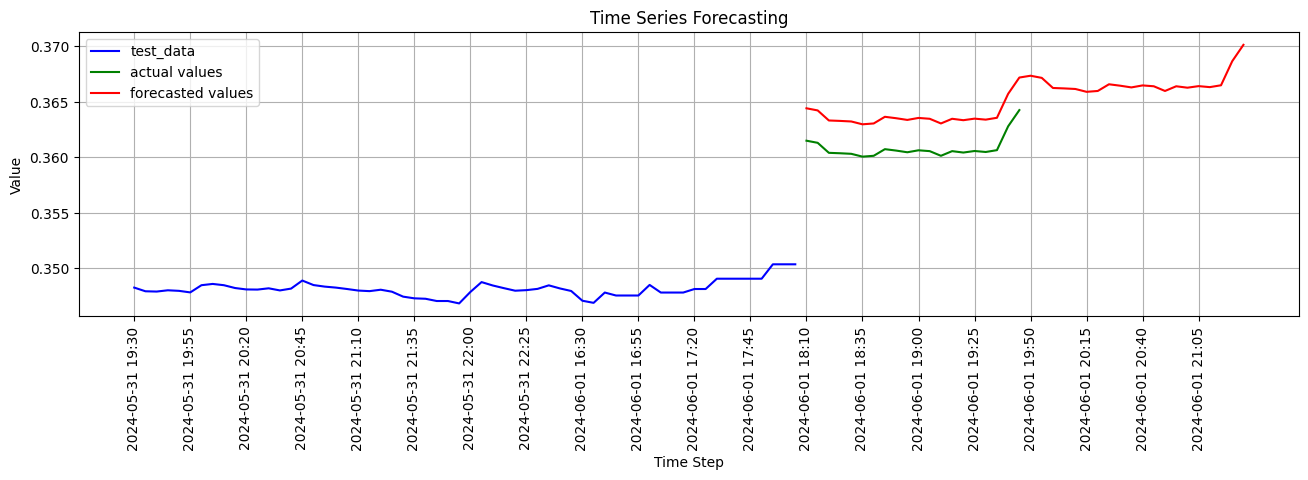

In [15]:

model = model.plot_forecasting()#, i_sequence_to_plot, i_forecasted_values, i_combined_index)